In [ ]:
import zipfile, os
zip_path = '/content/online_retail_II.csv.zip'
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall('/content/')
print("Extracted files:", os.listdir('/content'))


Extracted files: ['.config', 'online_retail_II.csv.zip', 'online_retail_II.csv', 'sample_data']


In [ ]:
# CELL 1 — Load & inspect
import os, pandas as pd
path = '/content/online_retail_II.csv'
print("Exists:", os.path.exists(path))
print("Size (MB):", round(os.path.getsize(path) / (1024*1024), 2))
df = pd.read_csv(path, nrows=5, encoding='latin1')
print("Preview (5 rows):")
display(df)
# now load without nrows for .info(); if file large, this will still be okay for most Colab RAMs
df_full = pd.read_csv(path, parse_dates=['InvoiceDate'], dayfirst=True, encoding='latin1')
print("\nFull load info:")
display(df_full.info())


Exists: True
Size (MB): 90.46
Preview (5 rows):


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom



Full load info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


None

In [ ]:
# CELL 2 — data quality checks
df = df_full  # use full dataframe variable
print("Rows:", len(df))
print("Columns:", df.columns.tolist())
print("Missing CustomerID:", df['CustomerID'].isna().sum())
print("Unique CustomerIDs (non-null):", df['CustomerID'].dropna().nunique())
print("Negative or zero Quantity rows:", (df['Quantity'] <= 0).sum())
# show sample cancelled invoices (InvoiceNo starting with C)
cancels = df[df['InvoiceNo'].astype(str).str.startswith('C')]
print("Cancelled invoice rows (sample 5):", len(cancels))
display(cancels.head())


Rows: 1067371
Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']


KeyError: 'CustomerID'

In [ ]:
# CELL A — standardize names & parse date
import pandas as pd, numpy as np

# assuming df_full already exists from previous cell; otherwise load file:
# df_full = pd.read_csv('/content/online_retail_II.csv', parse_dates=['InvoiceDate'], dayfirst=True, encoding='latin1')

# Standardize column names: strip, lower, replace spaces
df_full.columns = [c.strip().replace(' ', '_') for c in df_full.columns]
# Show current columns
print("Columns now:", df_full.columns.tolist())

# Rename to our expected names (defensive)
rename_map = {
    'Invoice': 'InvoiceNo',
    'StockCode': 'StockCode',
    'Description': 'Description',
    'Quantity': 'Quantity',
    'InvoiceDate': 'InvoiceDate',
    'Price': 'UnitPrice',           # rename Price -> UnitPrice for consistency with notebook
    'Customer_ID': 'CustomerID',    # note our earlier replacement ' '->'_'
    'Country': 'Country'
}
df_full = df_full.rename(columns={k:v for k,v in rename_map.items() if k in df_full.columns})

# Parse date explicitly (safe)
df_full['InvoiceDate'] = pd.to_datetime(df_full['InvoiceDate'], dayfirst=True, errors='coerce')

# Show quick info
print(df_full[['InvoiceNo','CustomerID','InvoiceDate','Quantity','UnitPrice']].head())
print("\nInfo summary:")
display(df_full.info())


Columns now: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer_ID', 'Country']
  InvoiceNo  CustomerID         InvoiceDate  Quantity  UnitPrice
0    489434     13085.0 2009-01-12 07:45:00        12       6.95
1    489434     13085.0 2009-01-12 07:45:00        12       6.75
2    489434     13085.0 2009-01-12 07:45:00        12       6.75
3    489434     13085.0 2009-01-12 07:45:00        48       2.10
4    489434     13085.0 2009-01-12 07:45:00        24       1.25

Info summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   InvoiceNo    1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  451178 non-null   datetime64[ns]
 5   UnitPr

None

In [ ]:
# CELL B — cleaning (uses standardized names)
df = df_full.copy()

# Remove cancellations (InvoiceNo starting with 'C') — defensive: InvoiceNo could be numeric or string
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df = df[~df['InvoiceNo'].str.startswith('C')]

# Remove zero/negative quantity or negative unit price
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] >= 0)]

# Drop rows without CustomerID
df = df.dropna(subset=['CustomerID'])

# Normalize CustomerID (float -> int -> str) safely
df['CustomerID'] = df['CustomerID'].astype(float).astype(int).astype(str)

# Derived variables
df['revenue'] = df['Quantity'] * df['UnitPrice']
df['InvoiceYearMonth'] = df['InvoiceDate'].dt.to_period('M').astype(str)

# Quick checks
print("Rows after cleaning:", len(df))
print("Unique customers:", df['CustomerID'].nunique())
print("Total revenue (clean):", round(df['revenue'].sum(),2))
df.head()


Rows after cleaning: 805620
Unique customers: 5881
Total revenue (clean): 17743429.18


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,revenue,InvoiceYearMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-01-12 07:45:00,6.95,13085,United Kingdom,83.4,2009-01
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-01-12 07:45:00,6.75,13085,United Kingdom,81.0,2009-01
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-01-12 07:45:00,6.75,13085,United Kingdom,81.0,2009-01
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-01-12 07:45:00,2.10,13085,United Kingdom,100.8,2009-01
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-01-12 07:45:00,1.25,13085,United Kingdom,30.0,2009-01


In [ ]:
# CELL C — write to SQLite and create customers summary
import sqlite3
db_path = '/content/online_retail_ii.db'
conn = sqlite3.connect(db_path)
df.to_sql('transactions', conn, if_exists='replace', index=False)

create_customers_sql = """
DROP TABLE IF EXISTS customers;
CREATE TABLE customers AS
SELECT
  CustomerID AS customer_id,
  MIN(InvoiceDate) AS first_tx,
  MAX(InvoiceDate) AS last_tx,
  COUNT(DISTINCT InvoiceNo) AS num_orders,
  SUM(revenue) AS total_revenue,
  AVG(revenue) AS avg_order_value
FROM transactions
GROUP BY CustomerID;
"""
cur = conn.cursor()
cur.executescript(create_customers_sql)
conn.commit()

print("Database written to", db_path)
for row in cur.execute("SELECT customer_id, total_revenue, num_orders FROM customers ORDER BY total_revenue DESC LIMIT 5;"):
    print(row)
cur.close()


Database written to /content/online_retail_ii.db
('18102', 608821.65, 145)
('14646', 528602.5200000026, 152)
('14156', 313946.3700000004, 156)
('14911', 295972.63000000146, 398)
('17450', 246973.09000000008, 51)


In [ ]:
# CELL D — cohort table and churn/RFM
import pandas as pd

# Cohort activity via SQL
cohort_sql = """
WITH cust_cohort AS (
  SELECT customer_id, strftime('%Y-%m', first_tx) AS cohort_month
  FROM customers
),
tx AS (
  SELECT CustomerID AS customer_id, strftime('%Y-%m', InvoiceDate) AS tx_month
  FROM transactions
)
SELECT c.cohort_month, t.tx_month, COUNT(DISTINCT t.customer_id) AS active_customers
FROM cust_cohort c
JOIN tx t ON c.customer_id = t.customer_id
GROUP BY c.cohort_month, t.tx_month
ORDER BY c.cohort_month, t.tx_month;
"""
cohort_df = pd.read_sql_query(cohort_sql, conn)
display(cohort_df.head(12))

# Load customers table to pandas
cust = pd.read_sql_query("SELECT * FROM customers", conn, parse_dates=['first_tx','last_tx'])
ds_last = pd.to_datetime(df['InvoiceDate'].max())
cust['days_since_last_tx'] = (ds_last - pd.to_datetime(cust['last_tx'])).dt.days
cust['churn_180d'] = (cust['days_since_last_tx'] > 180).astype(int)

# RFM
rfm = cust[['customer_id','first_tx','last_tx','num_orders','total_revenue','days_since_last_tx']].copy()
rfm['recency_days'] = rfm['days_since_last_tx']
rfm['frequency'] = rfm['num_orders']
rfm['monetary'] = rfm['total_revenue']

# handle edge cases for qcut: add tiny noise to avoid duplicate bin edges
rfm['recency_days_q'] = pd.qcut(rfm['recency_days'] + (np.random.rand(len(rfm))*0.0001), 4, labels=[4,3,2,1])
rfm['frequency_q'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['monetary_q'] = pd.qcut(rfm['monetary'] + (np.random.rand(len(rfm))*0.0001), 4, labels=[1,2,3,4])

rfm['RFM_score'] = rfm['recency_days_q'].astype(int) + rfm['frequency_q'].astype(int) + rfm['monetary_q'].astype(int)
rfm.sort_values('RFM_score').head()


,cohort_month,tx_month,active_customers
0,None,None,1602
1,2009-01,None,83
2,2009-01,2009-01,91
3,2009-01,2009-02,3
4,2009-01,2009-03,7
5,2009-01,2009-04,3
6,2009-01,2009-06,1
7,2009-01,2009-07,5
8,2009-01,2009-08,7
9,2009-01,2009-09,5


ValueError: Cannot convert float NaN to integer

In [ ]:
# Inspect missing InvoiceDate rows
missing_dates = df_full[df_full['InvoiceDate'].isna()]
print("Rows with missing InvoiceDate:", len(missing_dates))
# Show first 6 samples of problem rows (helpful to see pattern)
display(missing_dates[['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','Price','Customer_ID']].head(6))
# Show unique reasons: maybe different formats — show first 10 Invoice values
print("Sample InvoiceNo values for missing-date rows:", missing_dates['Invoice'].unique()[:10])


Rows with missing InvoiceDate: 616193


KeyError: "['Price', 'Customer_ID'] not in index"

In [ ]:
# FIXED CELL 1 — inspect missing InvoiceDate rows (uses UnitPrice, CustomerID)
missing_dates = df_full[df_full['InvoiceDate'].isna()]
print("Rows with missing InvoiceDate:", len(missing_dates))
# Show a small sample using actual column names
display(missing_dates[['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']].head(8))

# show first 10 distinct InvoiceNo values among missing-date rows (helps spot patterns)
print("Sample InvoiceNo values (missing-date rows):", missing_dates['InvoiceNo'].unique()[:10])


Rows with missing InvoiceDate: 616193


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
26218,491648,85135B,BLUE DRAGONFLY HELICOPTER,1,NaT,7.95,17243.0,United Kingdom
26219,491648,85136C,RED SHARK HELICOPTER,2,NaT,7.95,17243.0,United Kingdom
26220,491648,85136A,YELLOW SHARK HELICOPTER,2,NaT,7.95,17243.0,United Kingdom
26221,491648,85135A,YELLOW DRAGONFLY HELICOPTER,7,NaT,7.95,17243.0,United Kingdom
26222,491648,72802C,VANILLA SCENT CANDLE JEWELLED BOX,6,NaT,4.25,17243.0,United Kingdom
26223,491648,35001W,HAND OPEN SHAPE DECO.WHITE,1,NaT,3.49,17243.0,United Kingdom
26224,491648,22312,OFFICE MUG WARMER POLKADOT,12,NaT,4.95,17243.0,United Kingdom
26225,491648,82001S,VINYL RECORD FRAME SILVER,4,NaT,3.75,17243.0,United Kingdom


Sample InvoiceNo values (missing-date rows): ['491648' '491649' 'C491650' '491651' '491652' '491653' '491654' '491655'
 '491656' '491657']


In [ ]:
# FIXED CELL 2 — load raw CSV strings for InvoiceDate and inspect problematic rows
raw = pd.read_csv('/content/online_retail_II.csv', dtype=str, encoding='latin1', low_memory=False)
# show columns and sample
print("Raw columns:", raw.columns.tolist())
# show sample raw InvoiceDate strings for the rows that became NaT earlier
# match by InvoiceNo + StockCode + Quantity maybe - we'll find rows where parsed df_full had NaT and show corresponding raw strings
sample_keys = missing_dates[['InvoiceNo','StockCode','Quantity']].drop_duplicates().head(6)
print("Sample keys to inspect:", sample_keys.values.tolist())
for idx, row in sample_keys.iterrows():
    inv = row['InvoiceNo']; sc = row['StockCode']; qty = str(row['Quantity'])
    match = raw[(raw['Invoice']==str(inv)) & (raw['StockCode']==str(sc)) & (raw['Quantity']==str(qty))]
    print(f"\nMatches for Invoice {inv}, StockCode {sc}, Qty {qty}: {len(match)} rows")
    display(match[['Invoice','StockCode','Quantity','InvoiceDate']].head(6))


Raw columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']
Sample keys to inspect: [['491648', '85135B', 1], ['491648', '85136C', 2], ['491648', '85136A', 2], ['491648', '85135A', 7], ['491648', '72802C', 6], ['491648', '35001W', 1]]

Matches for Invoice 491648, StockCode 85135B, Qty 1: 1 rows


,Invoice,StockCode,Quantity,InvoiceDate
26218,491648,85135B,1,2009-12-13 09:58:00



Matches for Invoice 491648, StockCode 85136C, Qty 2: 1 rows


,Invoice,StockCode,Quantity,InvoiceDate
26219,491648,85136C,2,2009-12-13 09:58:00



Matches for Invoice 491648, StockCode 85136A, Qty 2: 1 rows


,Invoice,StockCode,Quantity,InvoiceDate
26220,491648,85136A,2,2009-12-13 09:58:00



Matches for Invoice 491648, StockCode 85135A, Qty 7: 1 rows


,Invoice,StockCode,Quantity,InvoiceDate
26221,491648,85135A,7,2009-12-13 09:58:00



Matches for Invoice 491648, StockCode 72802C, Qty 6: 1 rows


,Invoice,StockCode,Quantity,InvoiceDate
26222,491648,72802C,6,2009-12-13 09:58:00



Matches for Invoice 491648, StockCode 35001W, Qty 1: 1 rows


,Invoice,StockCode,Quantity,InvoiceDate
26223,491648,35001W,1,2009-12-13 09:58:00


In [ ]:
# FIXED CELL 3 — attempt robust re-parsing of InvoiceDate from raw strings
raw_dates = raw['InvoiceDate'].astype(str).copy()

# 1) try fast vectorized parse with dayfirst True
parsed1 = pd.to_datetime(raw_dates, dayfirst=True, errors='coerce')

# 2) try with infer_datetime_format=True
parsed2 = pd.to_datetime(raw_dates, infer_datetime_format=True, errors='coerce')

# 3) try ISO fallback (no dayfirst)
parsed3 = pd.to_datetime(raw_dates, dayfirst=False, errors='coerce')

print("Parsed counts: method1 dayfirst:", parsed1.notna().sum(),
      "| method2 infer:", parsed2.notna().sum(),
      "| method3 no-dayfirst:", parsed3.notna().sum())

# Combine: take first non-null from the three attempts
combined = parsed1.fillna(parsed2).fillna(parsed3)
print("Combined parsed count:", combined.notna().sum())

# Show a few examples where all attempts failed (to inspect odd strings)
failed_idx = combined[combined.isna()].index[:8]
display(raw.loc[failed_idx, ['Invoice','StockCode','Quantity','InvoiceDate']])


/tmp/ipython-input-3200062142.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed2 = pd.to_datetime(raw_dates, infer_datetime_format=True, errors='coerce')


Parsed counts: method1 dayfirst: 451178 | method2 infer: 1067371 | method3 no-dayfirst: 1067371
Combined parsed count: 1067371


,Invoice,StockCode,Quantity,InvoiceDate


In [ ]:
# CELL 4 — reload dataset with correct date parsing (no dayfirst)
import pandas as pd, numpy as np, sqlite3, os

path = '/content/online_retail_II.csv'
df = pd.read_csv(path, encoding='latin1', low_memory=False)
# Standardize names
df.columns = [c.strip().replace(' ', '_') for c in df.columns]
df.rename(columns={'Invoice':'InvoiceNo','Price':'UnitPrice','Customer_ID':'CustomerID'}, inplace=True)

# Correct parse (no dayfirst)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Basic cleaning
df = df[df['InvoiceDate'].notna()]  # now all should be valid, but safe guard
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] >= 0)]
df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(float).astype(int).astype(str)

# Derived columns
df['revenue'] = df['Quantity'] * df['UnitPrice']
df['InvoiceYearMonth'] = df['InvoiceDate'].dt.to_period('M').astype(str)

print("✅ Clean reload successful")
print("Rows:", len(df))
print("Unique customers:", df['CustomerID'].nunique())
print("Date range:", df['InvoiceDate'].min(), "→", df['InvoiceDate'].max())


✅ Clean reload successful
Rows: 805620
Unique customers: 5881
Date range: 2009-12-01 07:45:00 → 2011-12-09 12:50:00


In [ ]:
# CELL 5 — rebuild SQLite DB
db_path = '/content/online_retail_ii.db'
conn = sqlite3.connect(db_path)

df.to_sql('transactions', conn, if_exists='replace', index=False)

create_customers_sql = """
DROP TABLE IF EXISTS customers;
CREATE TABLE customers AS
SELECT
  CustomerID AS customer_id,
  MIN(InvoiceDate) AS first_tx,
  MAX(InvoiceDate) AS last_tx,
  COUNT(DISTINCT InvoiceNo) AS num_orders,
  SUM(revenue) AS total_revenue,
  AVG(revenue) AS avg_order_value
FROM transactions
GROUP BY CustomerID;
"""
cur = conn.cursor()
cur.executescript(create_customers_sql)
conn.commit()

print("Database rebuilt successfully.")
for row in cur.execute("SELECT customer_id, total_revenue, num_orders FROM customers ORDER BY total_revenue DESC LIMIT 5;"):
    print(row)
cur.close()


Database rebuilt successfully.
('18102', 608821.65, 145)
('14646', 528602.5200000026, 152)
('14156', 313946.3700000004, 156)
('14911', 295972.63000000146, 398)
('17450', 246973.09000000008, 51)


In [ ]:
# CELL 6 — Cohorts and RFM
cohort_sql = """
WITH cust_cohort AS (
  SELECT customer_id, strftime('%Y-%m', first_tx) AS cohort_month
  FROM customers
),
tx AS (
  SELECT CustomerID AS customer_id, strftime('%Y-%m', InvoiceDate) AS tx_month
  FROM transactions
)
SELECT c.cohort_month, t.tx_month, COUNT(DISTINCT t.customer_id) AS active_customers
FROM cust_cohort c
JOIN tx t ON c.customer_id = t.customer_id
GROUP BY c.cohort_month, t.tx_month
ORDER BY c.cohort_month, t.tx_month;
"""
cohort_df = pd.read_sql_query(cohort_sql, conn)
display(cohort_df.head(12))

cust = pd.read_sql_query("SELECT * FROM customers", conn, parse_dates=['first_tx','last_tx'])
ds_last = df['InvoiceDate'].max()
cust['days_since_last_tx'] = (ds_last - pd.to_datetime(cust['last_tx'])).dt.days
cust['churn_180d'] = (cust['days_since_last_tx'] > 180).astype(int)

rfm = cust[['customer_id','num_orders','total_revenue','days_since_last_tx']].copy()
rfm['recency_days'] = rfm['days_since_last_tx']
rfm['frequency'] = rfm['num_orders']
rfm['monetary'] = rfm['total_revenue']

rfm['recency_q'] = pd.qcut(rfm['recency_days'] + np.random.rand(len(rfm))*1e-6, 4, labels=[4,3,2,1])
rfm['frequency_q'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['monetary_q'] = pd.qcut(rfm['monetary'] + np.random.rand(len(rfm))*1e-6, 4, labels=[1,2,3,4])

rfm['recency_q'] = rfm['recency_q'].astype(int)
rfm['frequency_q'] = rfm['frequency_q'].astype(int)
rfm['monetary_q'] = rfm['monetary_q'].astype(int)
rfm['RFM_score'] = rfm['recency_q'] + rfm['frequency_q'] + rfm['monetary_q']

display(rfm.sort_values('RFM_score').head(), rfm.sort_values('RFM_score', ascending=False).head())
print("RFM rows:", len(rfm))


,cohort_month,tx_month,active_customers
0,2009-12,2009-12,955
1,2009-12,2010-01,337
2,2009-12,2010-02,319
3,2009-12,2010-03,406
4,2009-12,2010-04,363
5,2009-12,2010-05,343
6,2009-12,2010-06,360
7,2009-12,2010-07,327
8,2009-12,2010-08,321
9,2009-12,2010-09,346


,customer_id,num_orders,total_revenue,days_since_last_tx,recency_days,frequency,monetary,recency_q,frequency_q,monetary_q,RFM_score
53,12400,1,205.25,413,413,1,205.25,1,1,1,3
45,12392,1,234.75,590,590,1,234.75,1,1,1,3
40,12387,1,143.94,414,414,1,143.94,1,1,1,3
2357,14724,1,345.25,589,589,1,345.25,1,1,1,3
4902,17296,1,338.13,729,729,1,338.13,1,1,1,3


,customer_id,num_orders,total_revenue,days_since_last_tx,recency_days,frequency,monetary,recency_q,frequency_q,monetary_q,RFM_score
5852,18259,7,4318.20,24,24,7,4318.20,4,4,4,12
34,12380,11,9676.30,21,21,11,9676.30,4,4,4,12
5876,18283,22,2736.65,3,3,22,2736.65,4,4,4,12
1230,13590,18,6349.59,10,10,18,6349.59,4,4,4,12
1228,13588,9,2478.95,15,15,9,2478.95,4,4,4,12


RFM rows: 5881


Average profit margin: 40.0 %

Top 5 profitable customers:


,customer_id,total_revenue,profit,num_orders,first_tx,last_tx
5695,18102,608821.65,243528.660,145,2009-12-01 09:24:00,2011-12-09 11:50:00
2279,14646,528602.52,211441.008,152,2009-12-02 16:52:00,2011-12-08 12:12:00
1791,14156,313946.37,125578.548,156,2009-12-01 12:30:00,2011-11-30 10:54:00
2541,14911,295972.63,118389.052,398,2009-12-01 11:41:00,2011-12-08 15:54:00
5053,17450,246973.09,98789.236,51,2010-09-27 16:59:00,2011-12-01 13:29:00



Bottom 5 (least profitable) customers:


,customer_id,total_revenue,profit,num_orders,first_tx,last_tx
1739,14103,0.00,0.00,1,2010-02-12 14:58:00,2010-02-12 14:58:00
2458,14827,0.00,0.00,1,2010-02-12 15:47:00,2010-02-12 15:47:00
904,13256,0.00,0.00,1,2011-11-25 15:57:00,2011-11-25 15:57:00
1731,14095,2.95,1.18,1,2009-12-17 12:49:00,2009-12-17 12:49:00
4351,16738,3.75,1.50,1,2011-02-15 09:46:00,2011-02-15 09:46:00


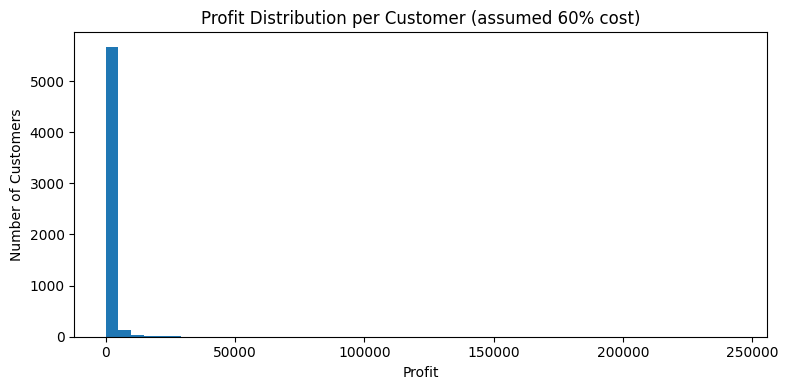

In [ ]:
# CELL 7 — customer-level profitability
import pandas as pd, matplotlib.pyplot as plt

assumed_cost_pct = 0.6
cust = pd.read_sql_query("SELECT * FROM customers", conn, parse_dates=['first_tx','last_tx'])

cust['assumed_cost'] = cust['total_revenue'] * assumed_cost_pct
cust['profit'] = cust['total_revenue'] - cust['assumed_cost']
cust['profit_margin_pct'] = 100 * (cust['profit'] / cust['total_revenue'])

top_profit = cust.sort_values('profit', ascending=False).head(10)
bottom_profit = cust.sort_values('profit', ascending=True).head(10)

print("Average profit margin:", round(cust['profit_margin_pct'].mean(), 2), "%")
print("\nTop 5 profitable customers:")
display(top_profit[['customer_id','total_revenue','profit','num_orders','first_tx','last_tx']].head())
print("\nBottom 5 (least profitable) customers:")
display(bottom_profit[['customer_id','total_revenue','profit','num_orders','first_tx','last_tx']].head())

# Plot profit distribution
plt.figure(figsize=(8,4))
plt.hist(cust['profit'], bins=50)
plt.title('Profit Distribution per Customer (assumed 60% cost)')
plt.xlabel('Profit')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()


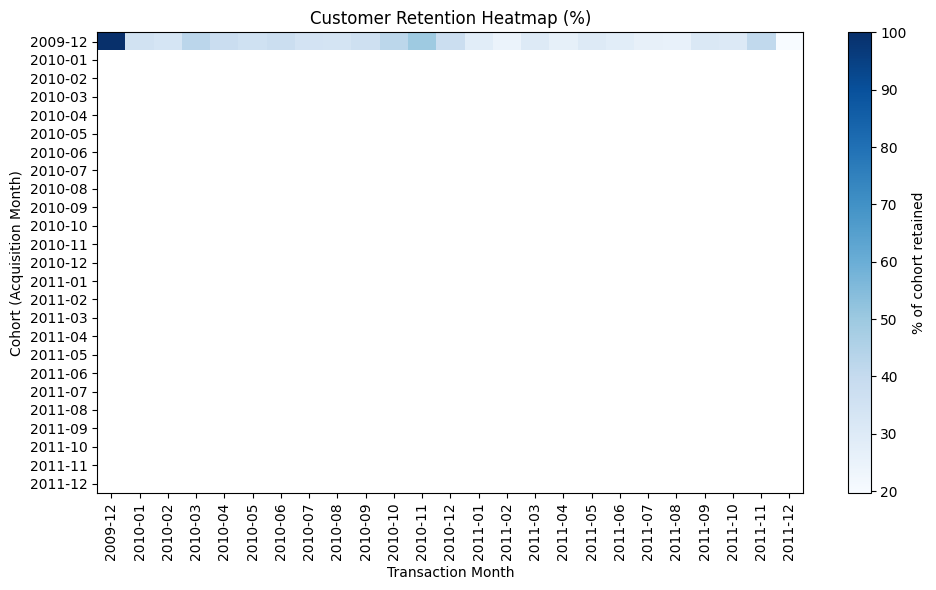

In [ ]:
# CELL 8 — cohort retention matrix
cohort_pivot = cohort_df.pivot(index='cohort_month', columns='tx_month', values='active_customers')

# Normalize to cohort size (first month per cohort)
cohort_sizes = cohort_pivot.iloc[:,0]
retention = cohort_pivot.divide(cohort_sizes, axis=0) * 100

plt.figure(figsize=(10,6))
plt.imshow(retention, aspect='auto', cmap='Blues', origin='upper')
plt.colorbar(label='% of cohort retained')
plt.xticks(ticks=range(len(retention.columns)), labels=retention.columns, rotation=90)
plt.yticks(ticks=range(len(retention.index)), labels=retention.index)
plt.title('Customer Retention Heatmap (%)')
plt.xlabel('Transaction Month')
plt.ylabel('Cohort (Acquisition Month)')
plt.tight_layout()
plt.show()


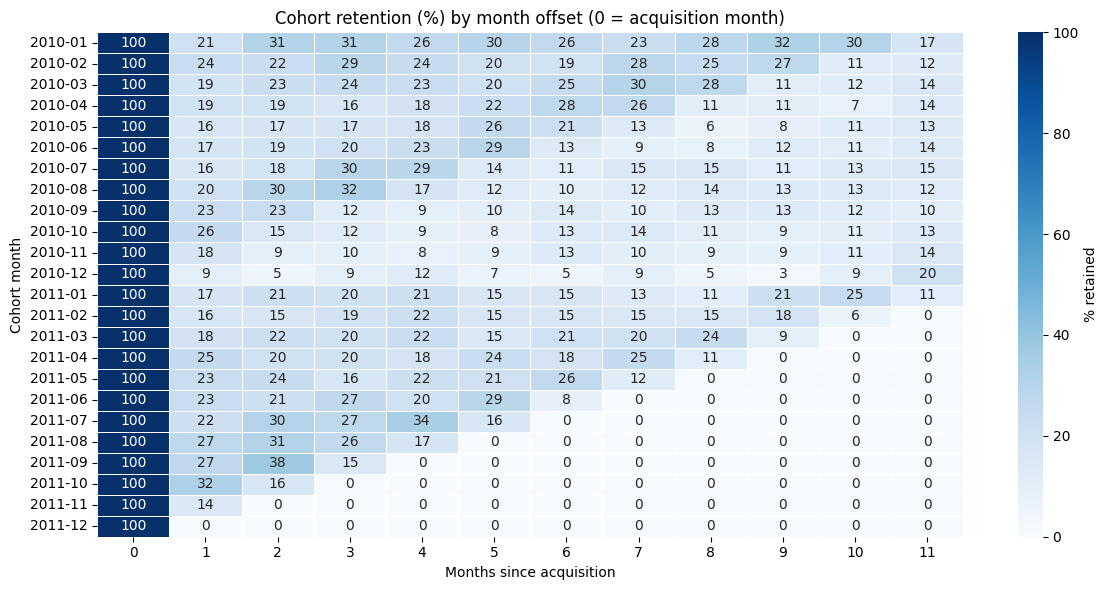

In [ ]:
# BETTER retention heatmap: cohort retention by month offset (0..11)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# build cohort sizes (customers acquired in cohort month)
cohort_sizes = cohort_df[cohort_df['cohort_month'].notna()].groupby('cohort_month')['active_customers'].first() \
              if 'active_customers' in cohort_df.columns else None

# safer: recompute cohort activity from SQL to ensure consistent counts (works with your conn)
sql = """
WITH cust_cohort AS (
  SELECT customer_id, strftime('%Y-%m', first_tx) AS cohort_month
  FROM customers
),
tx AS (
  SELECT CustomerID AS customer_id, strftime('%Y-%m', InvoiceDate) AS tx_month
  FROM transactions
)
SELECT c.cohort_month, t.tx_month, COUNT(DISTINCT t.customer_id) AS active_customers
FROM cust_cohort c
JOIN tx t ON c.customer_id = t.customer_id
GROUP BY c.cohort_month, t.tx_month
ORDER BY c.cohort_month, t.tx_month;
"""
cohort_activity = pd.read_sql_query(sql, conn)

# convert to Period for safe arithmetic
cohort_activity['cohort_month_p'] = pd.to_datetime(cohort_activity['cohort_month'] + '-01', errors='coerce')
cohort_activity['tx_month_p'] = pd.to_datetime(cohort_activity['tx_month'] + '-01', errors='coerce')

# compute month offset (0,1,2,...)
cohort_activity = cohort_activity.dropna(subset=['cohort_month_p','tx_month_p']).copy()
cohort_activity['month_offset'] = ((cohort_activity['tx_month_p'].dt.year - cohort_activity['cohort_month_p'].dt.year)*12 +
                                   (cohort_activity['tx_month_p'].dt.month - cohort_activity['cohort_month_p'].dt.month))

# keep first 12 offsets
cohort_activity = cohort_activity[cohort_activity['month_offset'].between(0,11)]

# pivot to matrix: rows=cohort_month, cols=month_offset
pivot = cohort_activity.pivot(index='cohort_month', columns='month_offset', values='active_customers').fillna(0)

# cohort sizes = month_offset 0 column
cohort_sizes = pivot[0].replace(0, np.nan)  # avoid divide-by-zero
retention_pct = pivot.div(cohort_sizes, axis=0) * 100
retention_pct = retention_pct.fillna(0)  # treat missing as 0%

# sort cohorts chronologically
retention_pct = retention_pct.sort_index()

# limit to most recent 24 cohorts if too many
max_cohorts = 24
retention_pct = retention_pct.tail(max_cohorts)

# plot heatmap
plt.figure(figsize=(12, max(6, 0.25*len(retention_pct))))
sns.heatmap(retention_pct, annot=True, fmt=".0f", cmap="Blues", cbar_kws={'label':'% retained'}, linewidths=.5)
plt.title("Cohort retention (%) by month offset (0 = acquisition month)")
plt.ylabel("Cohort month")
plt.xlabel("Months since acquisition")
plt.tight_layout()
plt.show()


In [ ]:
for cp in [0.5, 0.6, 0.7]:
    cust['profit_'+str(int(cp*100))] = cust['total_revenue'] * (1-cp)
    loss_count = (cust['profit_'+str(int(cp*100))] < 0).sum()
    print(cp, "loss-making customers:", loss_count)


0.5 loss-making customers: 0
0.6 loss-making customers: 0
0.7 loss-making customers: 0


In [ ]:
# A. Cohort LTV (python / pandas)
cost_pct = 0.6
tx = df.copy()   # 'df' is the cleaned transactions with revenue
tx['profit'] = tx['revenue'] * (1 - cost_pct)
tx['cohort_month'] = tx.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M').astype(str)
ltv = tx.groupby(['cohort_month','CustomerID'])['profit'].sum().reset_index()
ltv_cohort = ltv.groupby('cohort_month')['profit'].agg(['sum','mean','count']).rename(columns={'sum':'total_profit','mean':'avg_profit_per_customer','count':'num_customers'}).reset_index()
ltv_cohort.sort_values('cohort_month').head(10)


,cohort_month,total_profit,avg_profit_per_customer,num_customers
0,2009-12,3.489107e+06,3653.514705,955
1,2010-01,5.319234e+05,1388.833955,383
2,2010-02,4.011146e+05,1066.794048,376
3,2010-03,5.062674e+05,1142.815730,443
4,2010-04,2.242576e+05,762.781035,294
5,2010-05,1.569335e+05,617.848472,254
6,2010-06,2.439231e+05,903.418948,270
7,2010-07,1.269176e+05,682.352495,186
8,2010-08,1.083202e+05,668.643012,162
9,2010-09,2.337109e+05,961.773335,243


In [ ]:
# B. Profit concentration
cust_profit = cust.copy()   # `cust` table read earlier with total_revenue
cust_profit['profit_60'] = cust_profit['total_revenue'] * (1 - 0.6)
cust_profit = cust_profit.sort_values('profit_60', ascending=False)
total_profit = cust_profit['profit_60'].sum()
top1_count = int(0.01 * len(cust_profit))
top10_count = int(0.10 * len(cust_profit))
print("Top 1% contribution:", cust_profit.head(top1_count)['profit_60'].sum() / total_profit)
print("Top 10% contribution:", cust_profit.head(top10_count)['profit_60'].sum() / total_profit)


Top 1% contribution: 0.3176788605208816
Top 10% contribution: 0.6392565024050506


In [ ]:
# C. Add fixed costs and find loss-making
acq_cost = 5.0
support_cost_per_order = 2.0

cust2 = cust.copy()
cust2['support_cost'] = cust2['num_orders'] * support_cost_per_order
cust2['acq_cost'] = acq_cost
cust2['total_cost_est'] = cust2['total_revenue'] * 0.6 + cust2['support_cost'] + cust2['acq_cost']
cust2['profit_est'] = cust2['total_revenue'] - cust2['total_cost_est']
loss_makers = cust2[cust2['profit_est'] < 0]
print("Loss-making customers (example assumptions):", len(loss_makers))
loss_makers.head()


Loss-making customers (example assumptions): 18


,customer_id,first_tx,last_tx,num_orders,total_revenue,avg_order_value,assumed_cost,profit,profit_margin_pct,profit_50,profit_60,profit_70,support_cost,acq_cost,total_cost_est,profit_est
498,12846,2010-01-26 16:29:00,2010-01-26 16:29:00,1,15.58,15.58,9.348,6.232,40.0,7.790,6.232,4.674,2.0,5.0,16.348,-0.768
904,13256,2011-11-25 15:57:00,2011-11-25 15:57:00,1,0.00,0.00,0.000,0.000,NaN,0.000,0.000,0.000,2.0,5.0,7.000,-7.000
1425,13788,2010-07-22 15:50:00,2010-07-22 15:50:00,1,3.75,3.75,2.250,1.500,40.0,1.875,1.500,1.125,2.0,5.0,9.250,-5.500
1731,14095,2009-12-17 12:49:00,2009-12-17 12:49:00,1,2.95,2.95,1.770,1.180,40.0,1.475,1.180,0.885,2.0,5.0,8.770,-5.820
1739,14103,2010-02-12 14:58:00,2010-02-12 14:58:00,1,0.00,0.00,0.000,0.000,NaN,0.000,0.000,0.000,2.0,5.0,7.000,-7.000


In [ ]:
# D. At-risk list
at_risk = rfm[(rfm['recency_days'] > 60) & (rfm['RFM_score'] <= 6)].copy()
at_risk = at_risk.merge(cust[['customer_id','total_revenue','num_orders']], left_on='customer_id', right_on='customer_id')
at_risk.to_csv('/content/at_risk_customers.csv', index=False)
print("At-risk customers exported:", len(at_risk))


At-risk customers exported: 2131


In [ ]:
# B: exact counts for top 1% / top 10% customers
cust_profit = cust.copy()   # customers table from earlier
cust_profit['profit_60'] = cust_profit['total_revenue'] * (1 - 0.6)
cust_profit = cust_profit.sort_values('profit_60', ascending=False).reset_index(drop=True)
n = len(cust_profit)
top1_count = max(1, int(0.01 * n))
top10_count = max(1, int(0.10 * n))
top1_pct = cust_profit.head(top1_count)['profit_60'].sum() / cust_profit['profit_60'].sum()
top10_pct = cust_profit.head(top10_count)['profit_60'].sum() / cust_profit['profit_60'].sum()
print("customers:", n, "top1_count:", top1_count, "top10_count:", top10_count)
print("Top 1% contribution:", top1_pct)
print("Top 10% contribution:", top10_pct)


customers: 5881 top1_count: 58 top10_count: 588
Top 1% contribution: 0.3176788605208816
Top 10% contribution: 0.6392565024050506


In [ ]:
# C: loss-making with assumed costs (example assumptions)
acq_cost = 5.0
support_cost_per_order = 2.0
cost_pct = 0.6

cust2 = cust.copy()
cust2['assumed_cost'] = cust2['total_revenue'] * cost_pct
cust2['support_cost'] = cust2['num_orders'] * support_cost_per_order
cust2['acq_cost'] = acq_cost
cust2['total_cost_est'] = cust2['assumed_cost'] + cust2['support_cost'] + cust2['acq_cost']
cust2['profit_est'] = cust2['total_revenue'] - cust2['total_cost_est']
loss_makers = cust2[cust2['profit_est'] < 0].sort_values('profit_est')
display(loss_makers.head(20))
print("Loss-making customers:", len(loss_makers))


,customer_id,first_tx,last_tx,num_orders,total_revenue,avg_order_value,assumed_cost,profit,profit_margin_pct,profit_50,profit_60,profit_70,support_cost,acq_cost,total_cost_est,profit_est
904,13256,2011-11-25 15:57:00,2011-11-25 15:57:00,1,0.00,0.000000,0.000,0.000,NaN,0.000,0.000,0.000,2.0,5.0,7.000,-7.000
1739,14103,2010-02-12 14:58:00,2010-02-12 14:58:00,1,0.00,0.000000,0.000,0.000,NaN,0.000,0.000,0.000,2.0,5.0,7.000,-7.000
2458,14827,2010-02-12 15:47:00,2010-02-12 15:47:00,1,0.00,0.000000,0.000,0.000,NaN,0.000,0.000,0.000,2.0,5.0,7.000,-7.000
1731,14095,2009-12-17 12:49:00,2009-12-17 12:49:00,1,2.95,2.950000,1.770,1.180,40.0,1.475,1.180,0.885,2.0,5.0,8.770,-5.820
1425,13788,2010-07-22 15:50:00,2010-07-22 15:50:00,1,3.75,3.750000,2.250,1.500,40.0,1.875,1.500,1.125,2.0,5.0,9.250,-5.500
4351,16738,2011-02-15 09:46:00,2011-02-15 09:46:00,1,3.75,3.750000,2.250,1.500,40.0,1.875,1.500,1.125,2.0,5.0,9.250,-5.500
2423,14792,2011-10-07 09:19:00,2011-10-07 09:19:00,1,6.20,3.100000,3.720,2.480,40.0,3.100,2.480,1.860,2.0,5.0,10.720,-4.520
3535,15913,2010-06-23 16:31:00,2010-06-23 16:31:00,1,6.30,6.300000,3.780,2.520,40.0,3.150,2.520,1.890,2.0,5.0,10.780,-4.480
2667,15040,2010-06-16 11:40:00,2010-06-16 11:40:00,1,7.49,7.490000,4.494,2.996,40.0,3.745,2.996,2.247,2.0,5.0,11.494,-4.004
5708,18115,2010-01-11 11:57:00,2010-01-11 11:57:00,1,9.70,3.233333,5.820,3.880,40.0,4.850,3.880,2.910,2.0,5.0,12.820,-3.120


Loss-making customers: 18


In [ ]:
# Simulation: uplift for mid-tier (RFM 8-10)
cost_pct = 0.6
mid_tiers = rfm[(rfm['RFM_score']>=8) & (rfm['RFM_score']<=10)]
mid_ids = mid_tiers['customer_id'].tolist()
# historical avg profit per customer (6 months post-acq) by customer
tx = df.copy()
tx['profit'] = tx['revenue'] * (1 - cost_pct)
tx['cohort_month'] = tx.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M').astype(str)
# compute profit in first 6 months since customer first_tx
cust_first = tx.groupby('CustomerID')['InvoiceDate'].min().reset_index().rename(columns={'InvoiceDate':'first_tx'})
tx = tx.merge(cust_first, on='CustomerID', how='left')
tx['months_since_first'] = ((tx['InvoiceDate'].dt.year - tx['first_tx'].dt.year)*12 +
                           (tx['InvoiceDate'].dt.month - tx['first_tx'].dt.month))
first6 = tx[tx['months_since_first'].between(0,5)]
profit_first6 = first6.groupby('CustomerID')['profit'].sum().reset_index().rename(columns={'profit':'profit_6m'})
# baseline total profit for mid-tier customers
baseline = profit_first6[profit_first6['CustomerID'].isin(mid_ids)]['profit_6m'].sum()
# assume 10% absolute more customers remain from month1-3 => model as 10% uplift to avg profit_6m per mid customer
uplift_pct = 0.10
projected = baseline * (1 + uplift_pct)
print("Mid-tier baseline 6m profit:", baseline)
print("Projected with +10% retention uplift (modeled as +10% avg profit):", projected)
print("Incremental profit:", projected - baseline)


Mid-tier baseline 6m profit: 839857.7176
Projected with +10% retention uplift (modeled as +10% avg profit): 923843.48936
Incremental profit: 83985.77176000003


In [ ]:
df.to_csv('/content/clean_transactions.csv', index=False)
cust.to_csv('/content/customers_summary.csv', index=False)


In [13]:
import pandas as pd, os
raw_path = '/content/online_retail_II.csv.zip'   # CHANGE this to the actual path if different
print("Trying to load:", raw_path)
df = pd.read_csv(raw_path, encoding='latin1', low_memory=False)
print("Raw loaded:", df.shape)
# run minimal cleaning (adjust to your notebook's logic if necessary)
df.columns = [c.strip() for c in df.columns]
# unify column names
if 'Customer ID' in df.columns: df.rename(columns={'Customer ID':'CustomerID'}, inplace=True)
if 'InvoiceDate' in df.columns:
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True, errors='coerce')
# remove returned items if negative qty exists
if 'Quantity' in df.columns:
    df = df[df['Quantity']>0]
clean_transactions = df.copy()
# customers_summary minimal
customers_summary = clean_transactions.groupby('CustomerID').agg(
    num_orders=('Invoice', 'nunique'),
    total_revenue=('Price','sum') if 'Price' in df.columns else ('Quantity','sum'),
    first_tx=('InvoiceDate','min'),
    last_tx=('InvoiceDate','max')
).reset_index()
# at risk (60 days example)
ref = clean_transactions['InvoiceDate'].max()
customers_summary['DaysSinceLastTx'] = (ref - customers_summary['last_tx']).dt.days
at_risk_customers = customers_summary[customers_summary['DaysSinceLastTx']>60].copy()
print("Created cleaned DF shapes:", clean_transactions.shape, customers_summary.shape, at_risk_customers.shape)

# Save to Drive (mount and choose folder)
from google.colab import drive
drive.mount('/content/drive')
outdir='/content/drive/MyDrive/cpr_project'
os.makedirs(outdir, exist_ok=True)
clean_transactions.to_csv(os.path.join(outdir,'clean_transactions.csv'), index=False)
customers_summary.to_csv(os.path.join(outdir,'customers_summary.csv'), index=False)
at_risk_customers.to_csv(os.path.join(outdir,'at_risk_customers.csv'), index=False)
print("Saved cleaned CSVs to:", outdir)


Trying to load: /content/online_retail_II.csv.zip
Raw loaded: (1067371, 8)
Created cleaned DF shapes: (1044421, 8) (5881, 6) (3416, 6)


MessageError: Error: credential propagation was unsuccessful

In [15]:
# safe download helper
from google.colab import files as gfiles
gfiles.download('/content/sample_clean_transactions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
import pandas as pd
samp = pd.read_csv('/content/sample_clean_transactions.csv')
print(samp.dtypes)
print(samp['InvoiceDate'].head(8))


Invoice          int64
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
CustomerID     float64
Country         object
dtype: object
0                    NaN
1    2011-08-04 17:22:00
2                    NaN
3                    NaN
4                    NaN
5    2010-01-12 16:33:00
6                    NaN
7    2010-12-10 18:02:00
Name: InvoiceDate, dtype: object
